In [1]:
import gc

gc.collect()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import plotly.express as px
import holoviews as hv

import shap 

import warnings
warnings.filterwarnings('ignore')

shap.initjs()

# Get the current working directory
current_dir = os.getcwd()

# Navigate two directories back
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# define the data directory
data_dir = parent_dir + "/data/"
# This creates the full path to the output directory
Output = "results/"
output_dir = os.path.join(parent_dir, Output)

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
# Path to the 'src' directory
src_path = os.path.join(parent_dir, 'src')

# Loop through each entry in the 'src' directory
for item in os.listdir(src_path):
    full_path = os.path.join(src_path, item)
    # Check if the entry is a directory
    if os.path.isdir(full_path):
        # Add the directory to sys.path
        sys.path.append(full_path)

# Data Loading

In [3]:
# Loading data with weight

df = pd.read_csv(data_dir + '/application_train.csv')

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.loc[df.TARGET == 0, 'STATUS'] = 'GOOD'
df.loc[df.TARGET == 1, 'STATUS'] = 'DEFAULT'

In [4]:
# dropping SK_ID_CURR since it does not have any meaning for the model
df = df.drop(columns=['SK_ID_CURR'])

# Identifying Continuous and Discrete Features

In [5]:
# Assuming you have a dataframe named df

# Get the number of unique values for each column
unique_counts = df.nunique()
size = df.shape[0]

for col in df.columns:
    
    unique_counts[col] = 100*unique_counts[col]/(size - df[col].isna().sum())
    

# Print the result
unique_counts.head()

TARGET                0.000650
NAME_CONTRACT_TYPE    0.000650
CODE_GENDER           0.000976
FLAG_OWN_CAR          0.000650
FLAG_OWN_REALTY       0.000650
dtype: float64

In [6]:
max_cat = 10
cat_cutoff = max_cat*100/(df.shape[0]*0.08)
print(f'Cutoff to determine categorical data is <=: {cat_cutoff}')
categorical_columns = unique_counts[unique_counts <= cat_cutoff].index.tolist()

continuous_columns = unique_counts[unique_counts > cat_cutoff].index.tolist()

print(f'Number of Categorical Columns: {len(categorical_columns)}')
print(f'Number of Continuous Columns: {len(df.columns) - len(categorical_columns)}')

"""
# Create a bar plot
plt.plot(unique_counts[categorical_columns].index, unique_counts[categorical_columns])

# Set labels and title
plt.xlabel('Column')
plt.ylabel('Unique Counts')
plt.title('Unique Counts of DataFrame Columns')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()
"""

Cutoff to determine categorical data is <=: 0.04064895239519887
Number of Categorical Columns: 72
Number of Continuous Columns: 49


"\n# Create a bar plot\nplt.plot(unique_counts[categorical_columns].index, unique_counts[categorical_columns])\n\n# Set labels and title\nplt.xlabel('Column')\nplt.ylabel('Unique Counts')\nplt.title('Unique Counts of DataFrame Columns')\n\n# Rotate x-axis labels for better visibility\nplt.xticks(rotation=90)\n\n# Show the plot\nplt.show()\n"

In [ ]:
%%opts Bars[width=700 height=400 tools=['hover'] xrotation=45]{+axiswise +framewise}

from holoviews import opts

hv.extension('bokeh', 'matplotlib', logo=False)

# Categorical

cols = categorical_columns[:-1]

dd={}Finding

for col in cols:

    counts=df.groupby(col)['STATUS'].value_counts(normalize=False).to_frame('val').reset_index()
    dd[col] = hv.Bars(counts, [col, 'STATUS'], 'val') 
    
var = [*dd]
kdims=hv.Dimension(('var', 'Variable'), values=var)    
plot = hv.HoloMap(dd, kdims=kdims).opts(width=900, height=400, xrotation=45, axiswise=True, framewise=True)

# Save the plot to an HTML file
hv.save(plot, output_dir + 'class-distribution-categorical.html')

In [ ]:
from holoviews import opts
from bokeh.models import LinearAxis, Range1d

hv.extension('bokeh', 'matplotlib', logo=False)

# Continuous columns
#continuous_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
  # Replace with your actual continuous columns

# Define color mapping for STATUS
status_colors = {'Default': 'red', 'Good': 'darkgreen'}

dd = {}

for col in continuous_columns:
    
    dd[col] = hv.BoxWhisker(df,
                            kdims="STATUS",vdims=col,label=col).opts(
                                opts.BoxWhisker(width=500, height=400, xrotation=45, axiswise=True, framewise=True, 
                                                show_frame=True, cmap=status_colors, legend_position='right'))
    

# Create a HoloMap
var = [*dd]
kdims = hv.Dimension(('var', 'Variable'), values=var)
plot = hv.HoloMap(dd, kdims=kdims).opts(opts.Overlay(yaxis='both'))

# Save the plot to an HTML file with Bokeh
renderer = hv.renderer('bokeh')
bokeh_plot = renderer.get_plot(plot).state

# Add a secondary y-axis to the plot
bokeh_plot.add_layout(LinearAxis(y_range_name="right_axis"), 'right')
bokeh_plot.extra_y_ranges = {"right_axis": Range1d(start=bokeh_plot.y_range.start, end=bokeh_plot.y_range.end)}

# Save the plot to an HTML file
hv.save(plot, output_dir + 'class-distribution-continuous.html')

In [ ]:
unique_counts['LIVINGAPARTMENTS_AVG']

In [ ]:
df['LIVINGAPARTMENTS_AVG'].describe()

# Missing Values

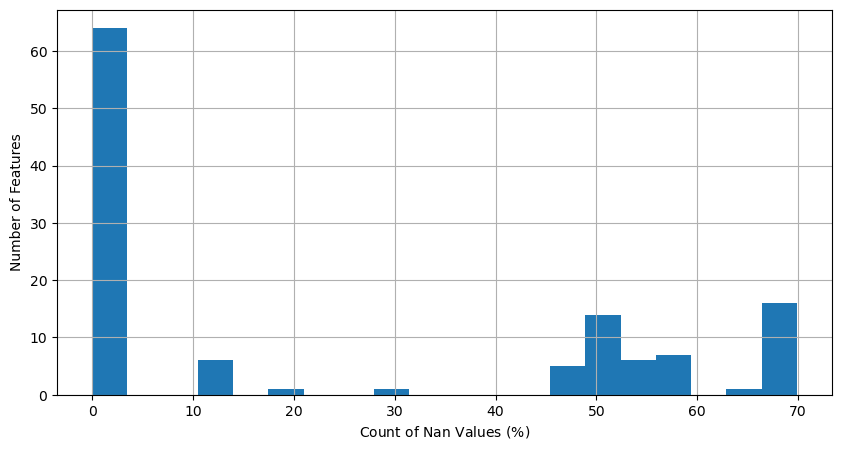

(307511, 54)

In [7]:
df_na = 100*df.isna().sum()/df.shape[0]

fig = plt.figure(figsize=(10, 5))
plt.xlabel(r'Count of Nan Values ($\%$)')
plt.ylabel('Number of Features')
df_na.hist(bins=20)

#fig.savefig(output_dir + 'missing-values-distribution.png',dpi=600,format='png',bbox_inches='tight')
plt.show()


no_nan_columns = df_na[df_na == 0].index.tolist()
impute_columns = df_na[df_na < 20].index.tolist()

nonan_continuous_columns = np.intersect1d(continuous_columns, no_nan_columns)
impute_continuous_columns = np.intersect1d(continuous_columns, impute_columns)

df_nonan = df[no_nan_columns]
df_nonan.shape

In [8]:
len(impute_columns), len(no_nan_columns)

(71, 54)

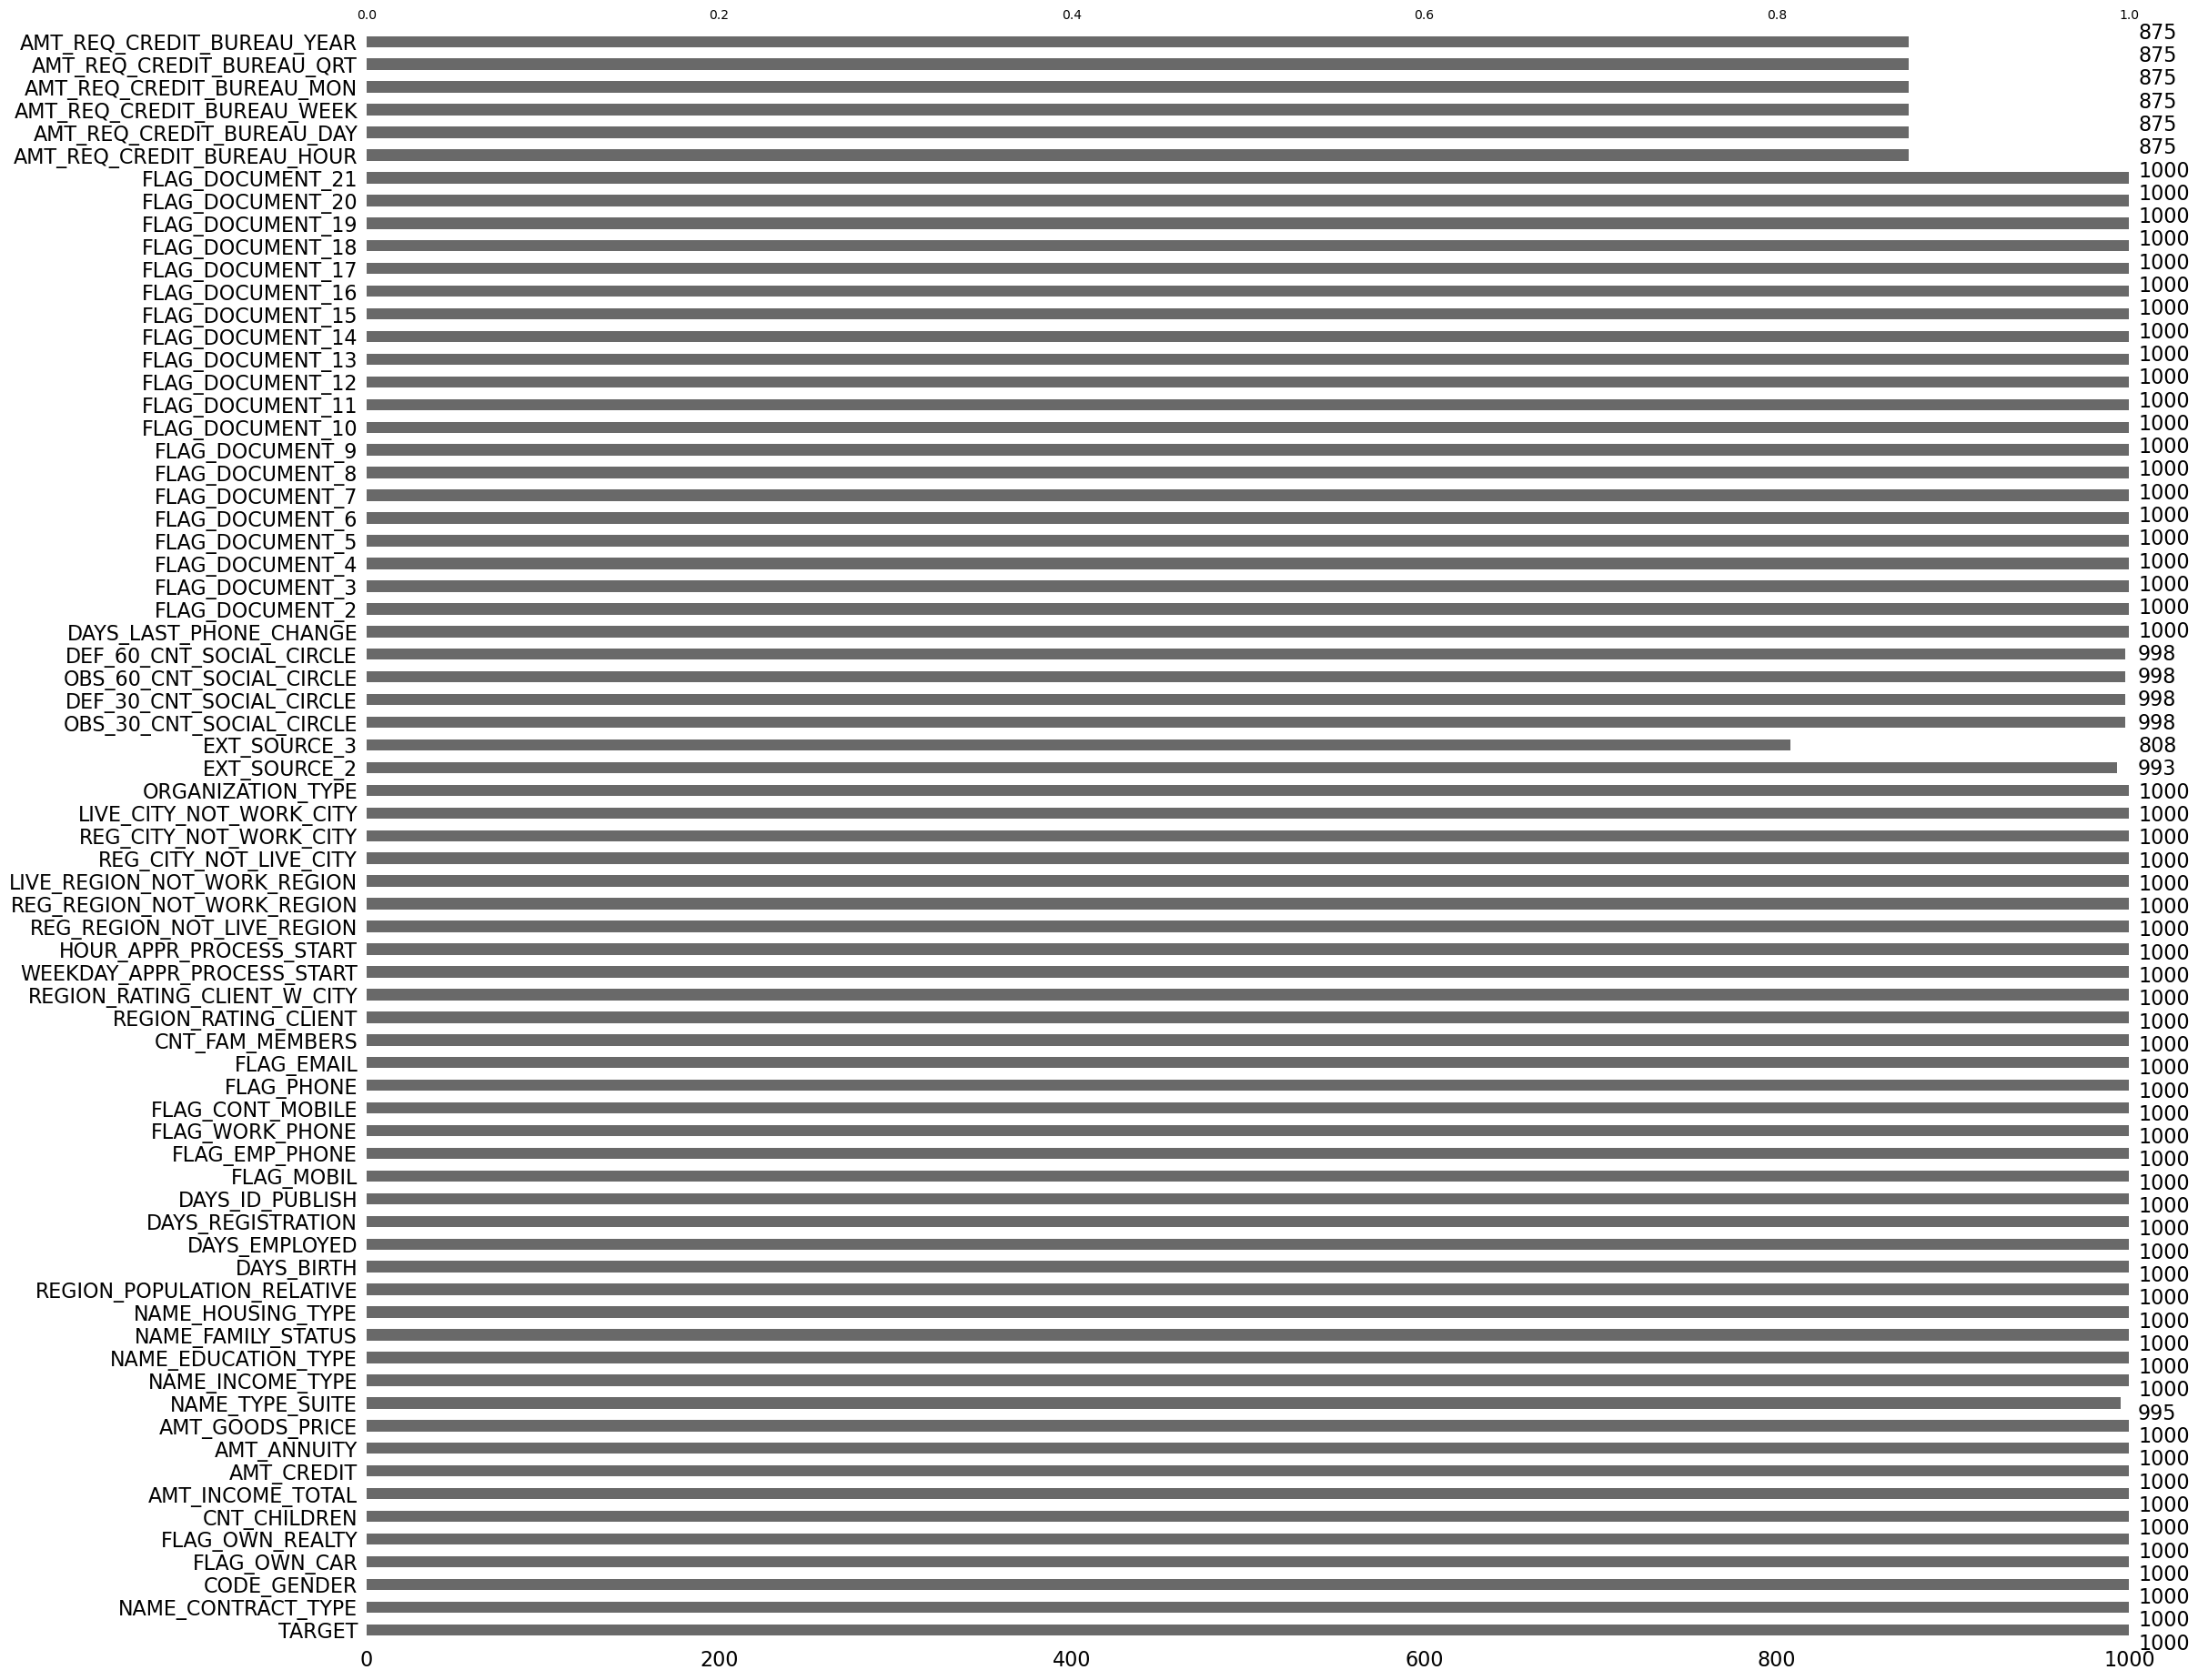

In [11]:
import missingno as msno 

# Plot correlation heatmap of missingness
fig = plt.figure(figsize=(12, 10))
f = msno.bar(df[impute_columns].sample(1000))
#fig.savefig(output_dir + 'missing-values-by-columns.png',dpi=100,format='png',bbox_inches='tight')
#msno.matrix(df);

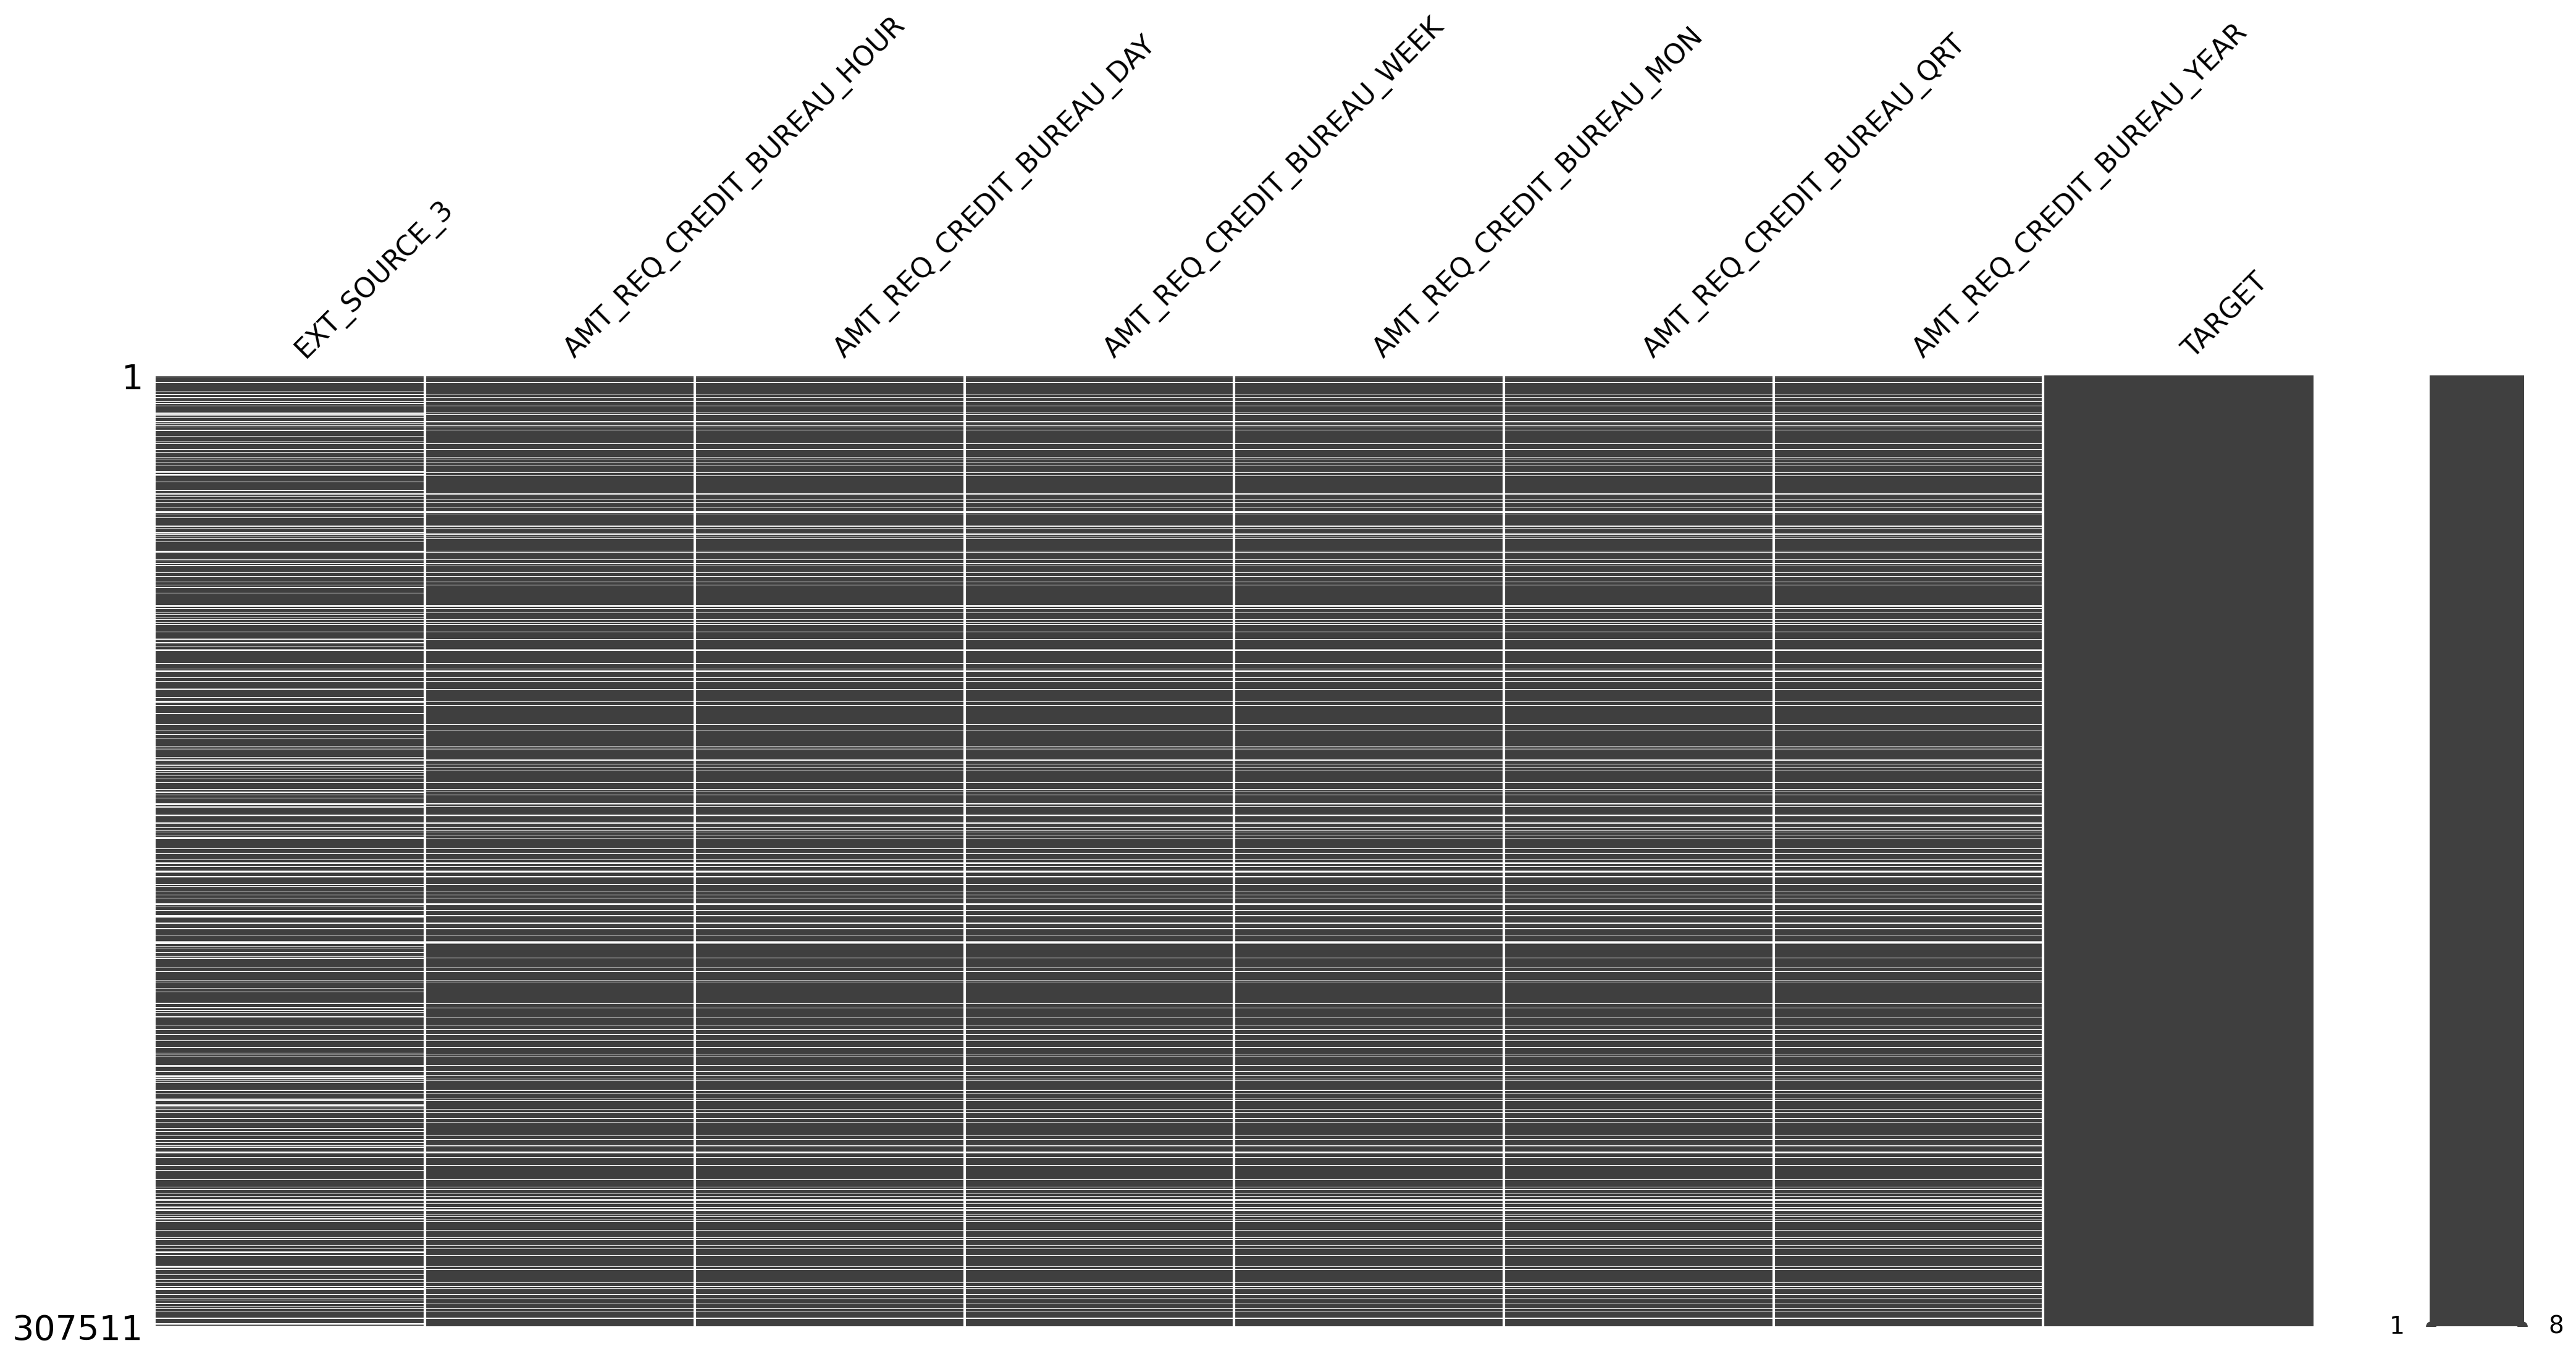

In [16]:
slcted_columns = df_na[(df_na < 20) & (df_na >= 1)].index.tolist()
slcted_columns.append('TARGET')
msno.matrix(df[slcted_columns]);

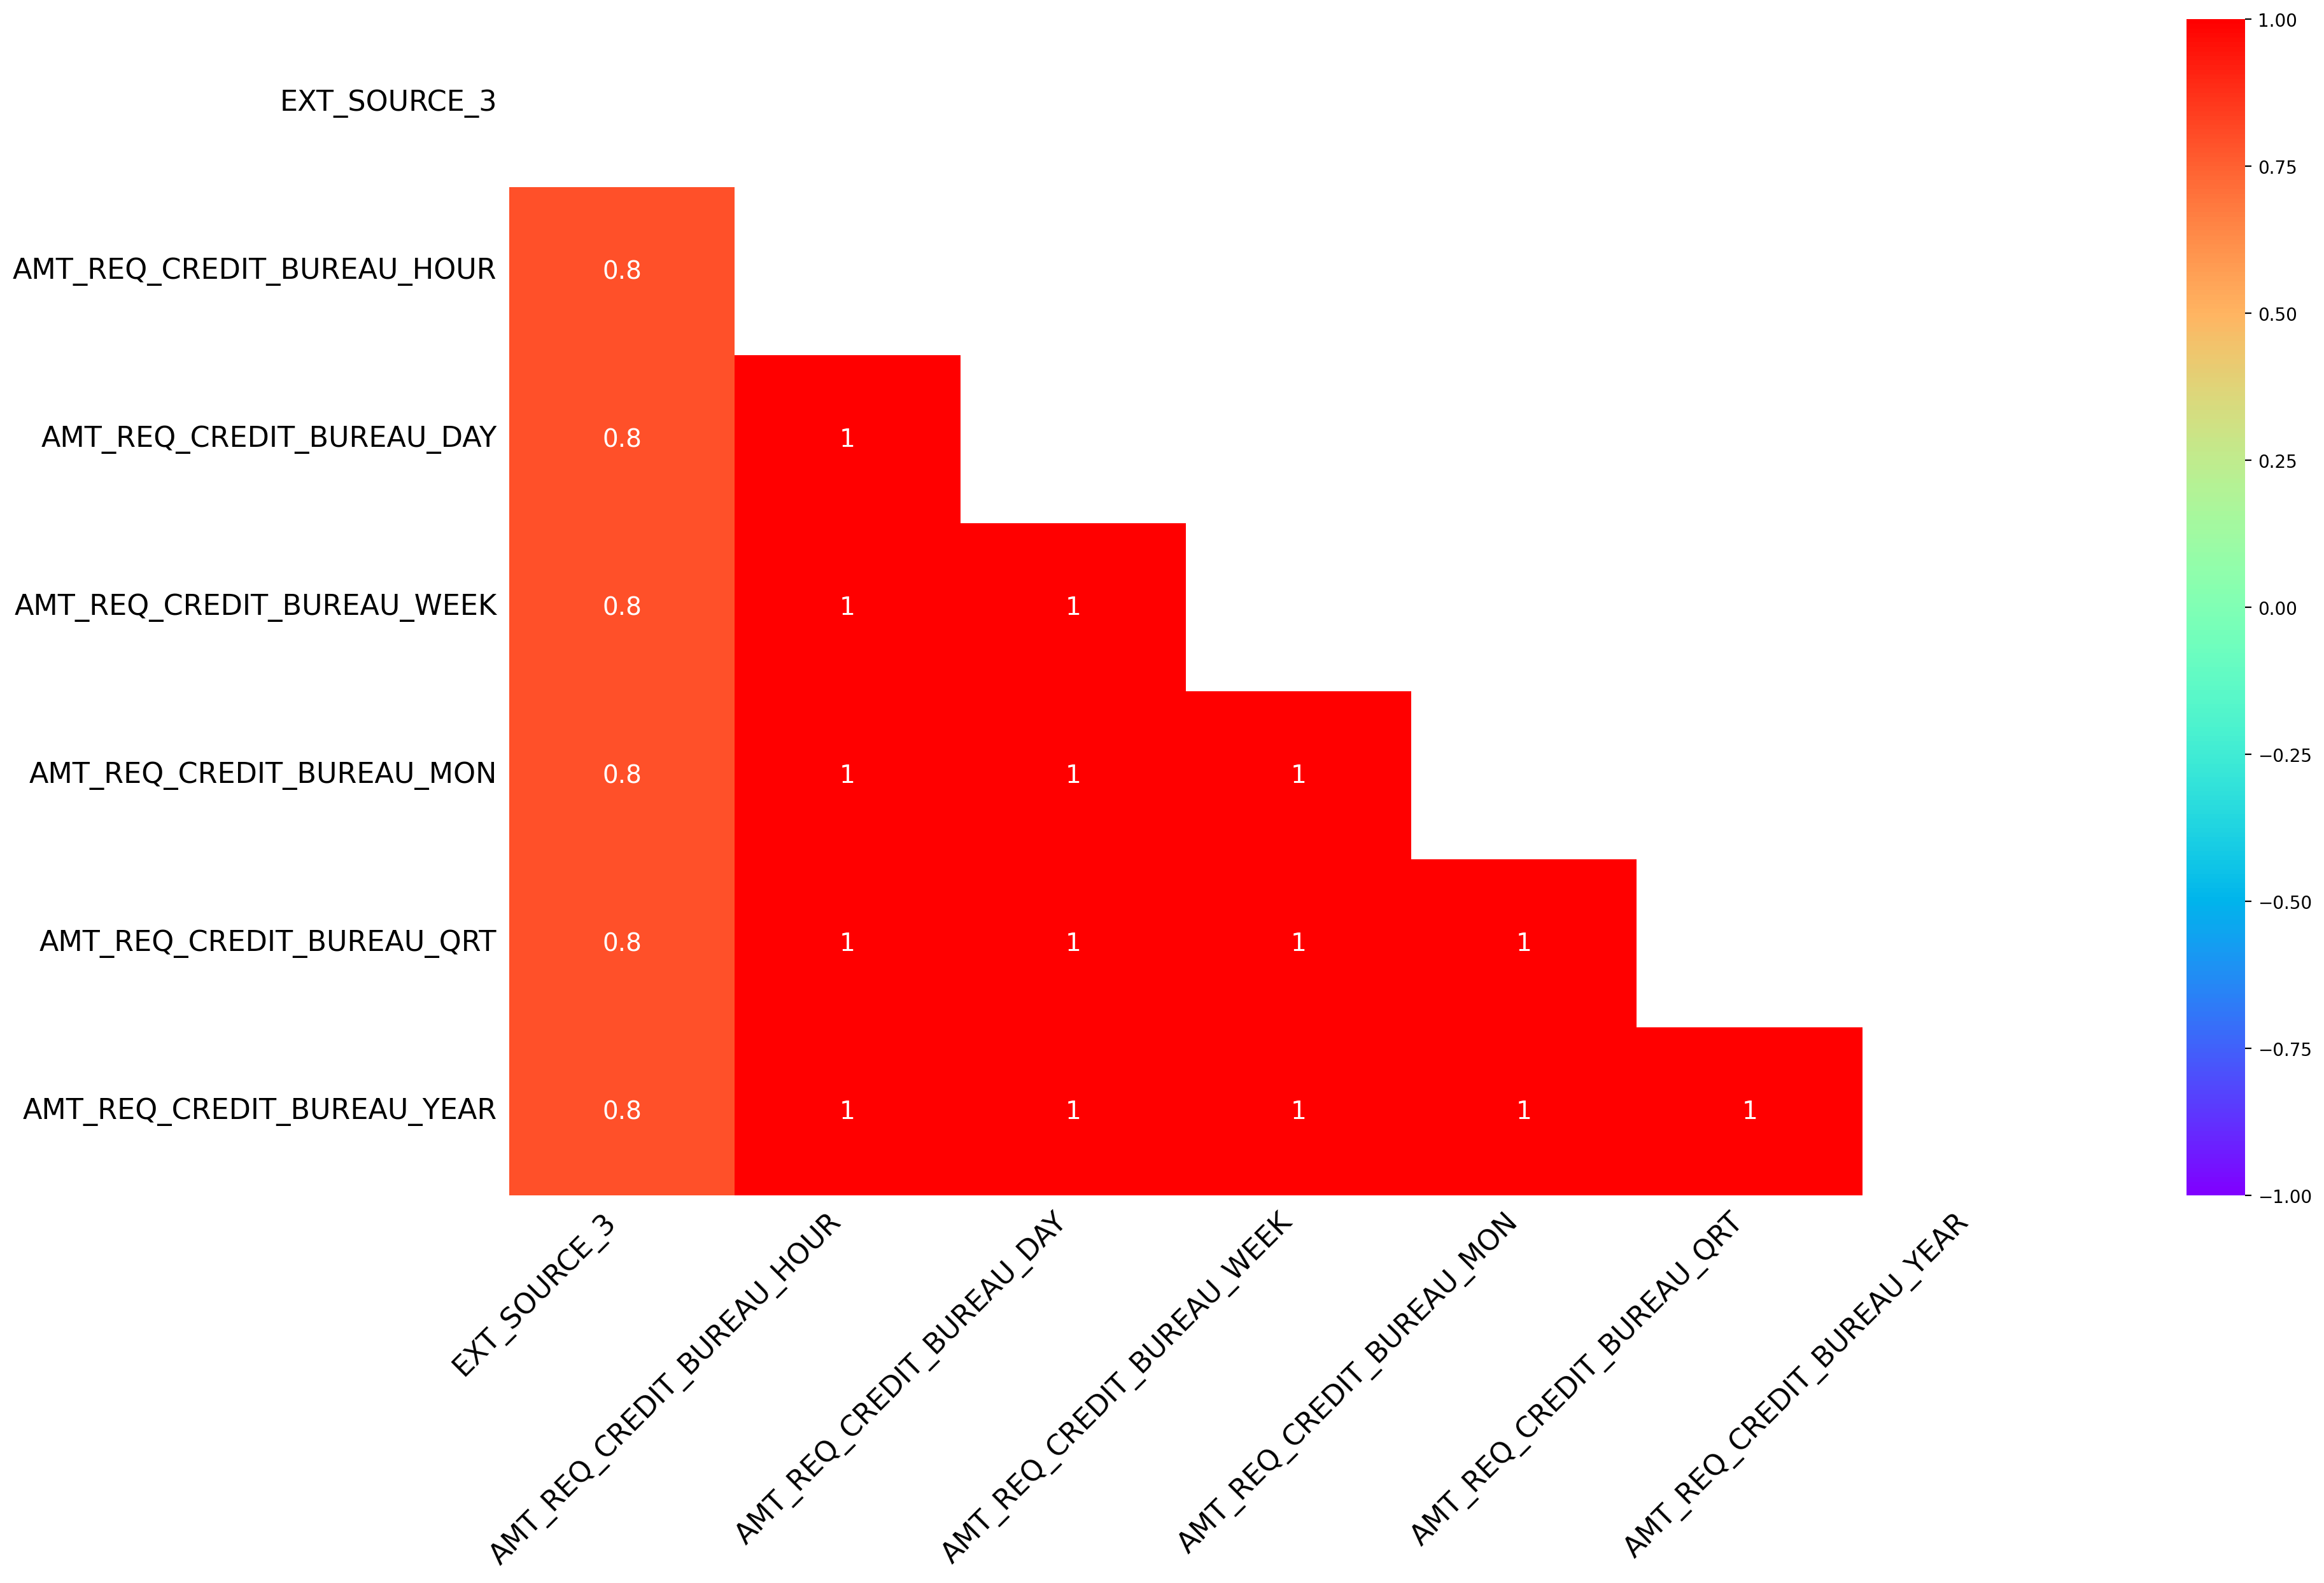

In [19]:
msno.heatmap(df[slcted_columns], cmap='rainbow');

In [18]:
slcted_columns

['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'TARGET']

## Imputing

In [21]:
from fn_encoding import ordinal_encode

nonan_cat_columns = np.intersect1d(categorical_columns, impute_columns)

df = ordinal_encode(df, nonan_cat_columns)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1.0,0.0,1.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.impute import KNNImputer

# Copy the data
df_knn_imputed = df[slcted_columns].copy(deep=True)

# Init the transformer
knn_imp = KNNImputer(n_neighbors=2)

# Fit/transform
df_knn_imputed.loc[:, :] = knn_imp.fit_transform(df_knn_imputed)

df_knn_imputed[slcted_columns].isnull().sum()

KeyboardInterrupt: 

# Detecting Outliers

In [ ]:
# Checkking Distributions
#%%opts Bars[width=700 height=400 tools=['hover'] xrotation=45]{+axiswise +framewise}

# Create a histogram for each column


from holoviews import opts
from bokeh.models import LinearAxis, Range1d

hv.extension('bokeh', 'matplotlib', logo=False)

# Function to calculate the number of bins using Freedman-Diaconis rule
def freedman_diaconis_bins(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(data) ** (-1/3)
    bins = int(np.ceil((data.max() - data.min()) / bin_width))
    return bins

# Continuous columns
#continuous_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
  # Replace with your actual continuous columns

# Define color mapping for STATUS
status_colors = {'Default': 'red', 'Good': 'lightgreen'}

dd = {}

for col in nonan_continuous_columns:
    
    # Create histograms for each STATUS value
    hist_default_data = df[df['STATUS'] == 'DEFAULT'][col]
    hist_good_data = df[df['STATUS'] == 'GOOD'][col]

    # Calculate the number of bins using Freedman-Diaconis rule
    bins_default = freedman_diaconis_bins(hist_default_data)
    bins_good = freedman_diaconis_bins(hist_good_data)

    # Use the maximum number of bins to ensure consistency in overlay
    bins = max(bins_default, bins_good)

    # Determine the range for x and y axes
    x_range = 0.95*df[col].min(), 1.05*df[col].max()
    #(0.95*min(hist_default_data.min(), hist_good_data.min()), 1.1*max(hist_default_data.max(), hist_good_data.max()))
    y_max = 1.1*max(np.histogram(hist_default_data, bins=bins_default)[0].max(), np.histogram(hist_good_data, bins=bins_good)[0].max())

    # Create histograms for each STATUS value
    hist_default = hv.Histogram(np.histogram(hist_default_data, bins=bins_default), 
                                label='Default').opts(color='red', alpha=0.9, xlim=x_range, ylim=(0, y_max), framewise=True)
    hist_good = hv.Histogram(np.histogram(hist_good_data, bins=bins_good), 
                             label='Good').opts(color='lightgreen', alpha=0.3, xlim=x_range, ylim=(0, y_max), framewise=True)
    

    dd[col] = (hist_default * hist_good).opts(
        opts.Overlay(width=900, height=400, xrotation=45, 
                     legend_position='top', xlim=x_range, ylim=(0, y_max), shared_axes=True, framewise=True))
    

# Create a HoloMap
var = [*dd]
kdims = hv.Dimension(('var', 'Variable'), values=var)
plot = hv.HoloMap(dd, kdims=kdims)


In [ ]:
# Save the plot to an HTML file
hv.save(plot, output_dir + 'non-nan-histograms-continuous.html')

## Encoding

In [25]:
from fn_encoding import ordinal_encode

nonan_cat_columns = np.intersect1d(categorical_columns, no_nan_columns)

df = ordinal_encode(df, nonan_cat_columns)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,STATUS
0,1.0,0.0,1.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# Define the file path for saving the CSV file
csv_file_path = data_dir + "/cleaned/no_nan_ordinal_encoded.csv"

# Save the DataFrame as a CSV file
df[no_nan_columns].to_csv(csv_file_path, index=False)

## Isolation Forest

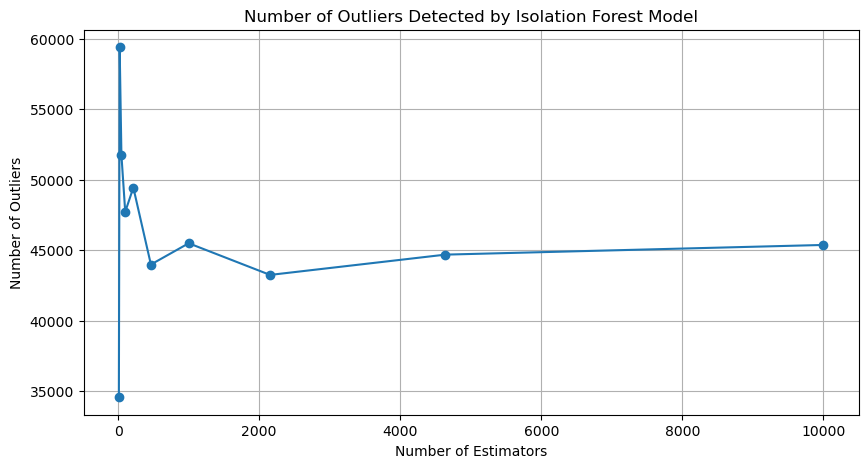

In [40]:
from sklearn.ensemble import IsolationForest

X = df.drop(columns=['STATUS', 'TARGET'])

columns_isolation = [column for column in no_nan_columns if column not in ['STATUS', 'TARGET']]

def isolation_forest(X, columns, n_estimators=100, contamination='auto', max_samples='auto'):
    # Create an Isolation Forest model
    iforest = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples =max_samples)
    prediction = iforest.fit_predict(X[columns])

    n_outliers = (prediction == -1).sum()

    return n_outliers
    
ary_outliers = np.array([])
ary_estimators = np.logspace(1, 4, num=10, base=10.0, endpoint=True, dtype=int)

for i in ary_estimators:
    n_outliers = isolation_forest(X, columns_isolation, n_estimators=i)
    ary_outliers = np.append(ary_outliers, n_outliers)

# plot the number of outliers detected by the Isolation Forest model
fig = plt.figure(figsize=(10, 5))
plt.plot(ary_estimators, ary_outliers, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers Detected by Isolation Forest Model')
plt.grid(True)
fig.savefig(output_dir + 'outliers_iforest-vs-estiators.png',dpi=600,format='png',bbox_inches='tight')
plt.show()

In [37]:
# Create an Isolation Forest model
iforest = IsolationForest(n_estimators = 1000, contamination = 'auto', max_samples ='auto')
prediction = iforest.fit_predict(X[columns_isolation])

n_outliers = (prediction == -1).sum()
print("Number of outliers detected: {}".format(n_outliers))
print("Percentage of Outliers: {}".format(100*n_outliers/X.shape[0]))

Number of outliers detected: 45976
Percentage of Outliers: 14.951009882573306


## Z-Score

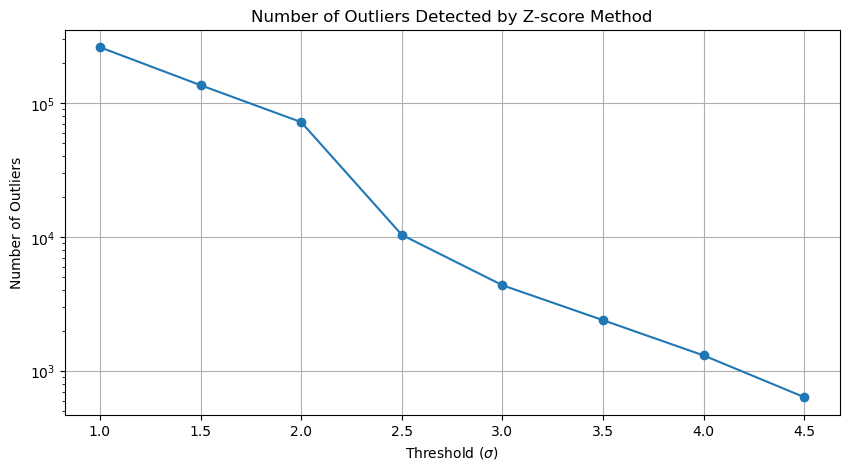

In [96]:
from scipy.stats import zscore

def detect_outliers_zscore(X, columns, threshold=4):
    # Calculate Z-scores for each data point
    z_scores = zscore(X[columns])
    # Identify outliers
    outliers = (z_scores > threshold) | (z_scores < -threshold)
    false_rows_count = (outliers == True).any(axis=1).sum()
    return false_rows_count


ary_outliers = np.array([])
ary_thresholds = np.arange(1, 5, 0.5)


for i in ary_thresholds:
    n_outliers = detect_outliers_zscore(X, nonan_continuous_columns, threshold=i)
    ary_outliers = np.append(ary_outliers, n_outliers)

# plot the number of outliers detected by Z-score method
fig = plt.figure(figsize=(10, 5))
plt.plot(ary_thresholds, ary_outliers, marker='o')
plt.yscale('log')
plt.xlabel(r'Threshold $(\sigma)$')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers Detected by Z-score Method')
plt.grid(True)
fig.savefig(output_dir + 'outliers_zscore-vs-threshold.png',dpi=600,format='png',bbox_inches='tight')
plt.show()

## Robust Random Cut Forest